Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.8 GB
Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


Training samples: 60000
Test samples: 10000
Model parameters: 1,199,882

Starting training...
Epoch 1/5, Batch 0/235, Loss: 2.3032
Epoch 1/5, Batch 100/235, Loss: 0.1436
Epoch 1/5, Batch 200/235, Loss: 0.1498
Epoch 1/5: Loss=0.2668, Accuracy=91.84%, Time=11.8s
Epoch 2/5, Batch 0/235, Loss: 0.1126
Epoch 2/5, Batch 100/235, Loss: 0.0672
Epoch 2/5, Batch 200/235, Loss: 0.0562
Epoch 2/5: Loss=0.0903, Accuracy=97.32%, Time=11.8s
Epoch 3/5, Batch 0/235, Loss: 0.0688
Epoch 3/5, Batch 100/235, Loss: 0.0966
Epoch 3/5, Batch 200/235, Loss: 0.0648
Epoch 3/5: Loss=0.0686, Accuracy=97.90%, Time=11.7s
Epoch 4/5, Batch 0/235, Loss: 0.0659
Epoch 4/5, Batch 100/235, Loss: 0.0395
Epoch 4/5, Batch 200/235, Loss: 0.0715
Epoch 4/5: Loss=0.0550, Accuracy=98.31%, Time=11.8s
Epoch 5/5, Batch 0/235, Loss: 0.0220
Epoch 5/5, Batch 100/235, Loss: 0.0454
Epoch 5/5, Batch 200/235, Loss: 0.0189
Epoch 5/5: Loss=0.0483, Accuracy=98.52%, Time=12.2s

Total training time: 59.3 seconds

Testing model...
Test Loss: 0.0264,

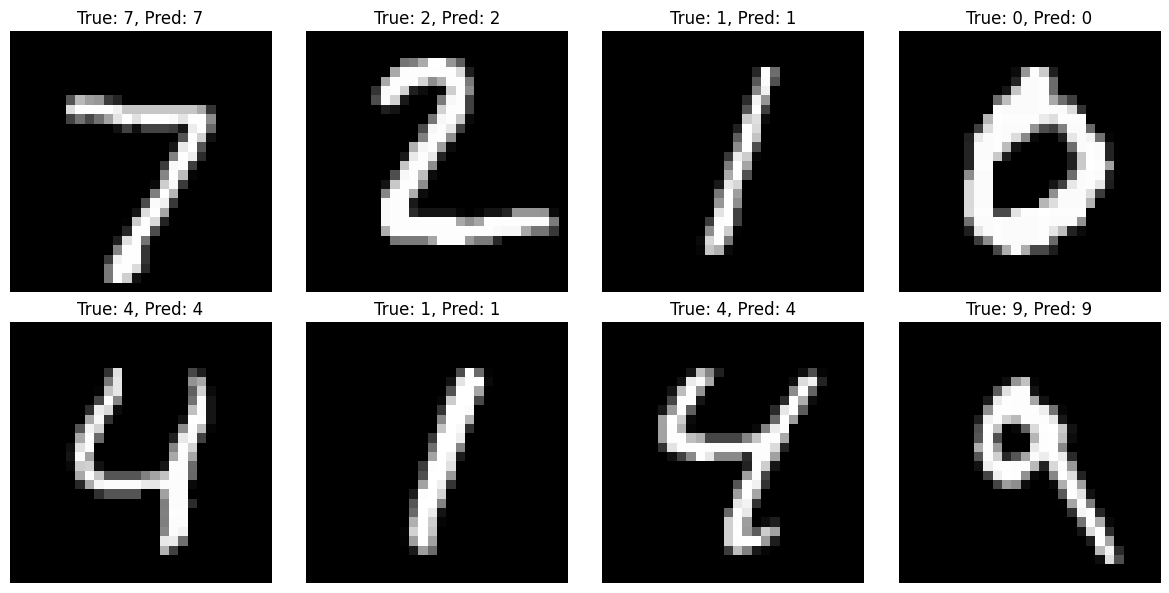

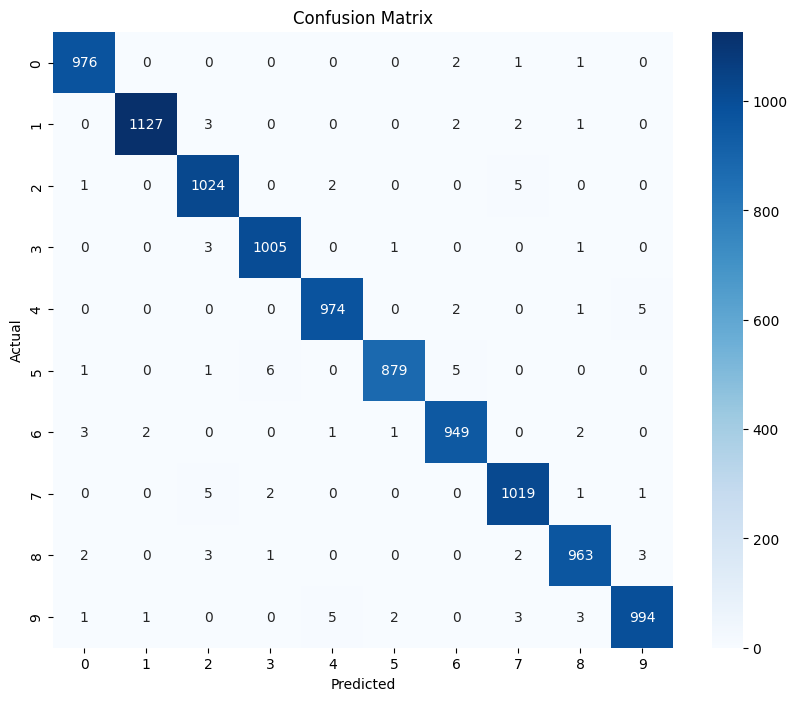


Model saved as 'mnist_model.pth'

READY FOR PREDICTIONS!
Use predict_single_image(model, your_image_tensor) to predict new images


In [1]:
# MNIST Prediction Algorithm for Tesla T4 GPU
# Optimized for Google Colab

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST dataset
print("Loading MNIST dataset...")
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

# Create data loaders (optimized batch size for T4)
batch_size = 256  # Good balance for T4's 16GB memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Simple but effective neural network for MNIST
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# CNN version (more GPU-friendly)
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

# Choose model (CNN performs better and utilizes GPU more effectively)
model = MNISTCNN().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, '
              f'Accuracy={epoch_acc:.2f}%, Time={epoch_time:.1f}s')

    return train_losses, train_accuracies

# Test function
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_predictions.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return accuracy, all_predictions, all_targets

# Train the model
print("\nStarting training...")
start_total = time.time()
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs=5)
total_time = time.time() - start_total
print(f"\nTotal training time: {total_time:.1f} seconds")

# Test the model
print("\nTesting model...")
test_accuracy, predictions, targets = test_model(model, test_loader)

# Detailed results
print("\nClassification Report:")
print(classification_report(targets, predictions))

# Visualize some predictions
def visualize_predictions(model, test_loader, num_images=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    with torch.no_grad():
        data, target = next(iter(test_loader))
        data, target = data.to(device), target.to(device)
        output = model(data)
        predictions = output.argmax(dim=1)

        for i in range(num_images):
            img = data[i].cpu().squeeze()
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'True: {target[i].item()}, Pred: {predictions[i].item()}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(targets, predictions):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Performance monitoring function
def gpu_memory_usage():
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated() / 1e9
        memory_total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory Usage: {memory_used:.2f}GB / {memory_total:.2f}GB")

# Prediction function for new images
def predict_single_image(model, image_tensor):
    """Predict a single image"""
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        if len(image_tensor.shape) == 3:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    return predicted_class, confidence

# Display results
print(f"\n{'='*50}")
print("MNIST PREDICTION RESULTS")
print(f"{'='*50}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Total Training Time: {total_time:.1f} seconds")

# Show GPU memory usage
gpu_memory_usage()

# Visualize results
visualize_predictions(model, test_loader)
plot_confusion_matrix(targets, predictions)

# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')
print("\nModel saved as 'mnist_model.pth'")

print("\n" + "="*50)
print("READY FOR PREDICTIONS!")
print("="*50)
print("Use predict_single_image(model, your_image_tensor) to predict new images")